# MODS202 - Project
## SOUZA PINTO MEDEIROS, Gabriel

In [413]:
import math                           
import numpy as np                    
from sklearn import linear_model      
from os import mkdir                  
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import scipy.stats as stats
import seaborn as sn
import statsmodels.api as sm 
from scipy.stats import t
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf

## Part 1: Regression
### 1.1

In [414]:
fields = ['inlf','hours','kidslt6','kidsge6','age','educ','wage','repwage','hushrs','husage','huseduc','huswage',
          'faminc','mtr','motheduc','fatheduc', 'unem','city','exper','nwifeinc','lwage','expersq'] #Columns observed
filename = 'MROZ.txt' #If the dataset is not in the same directory as this notebook
#please change the filepath to the correct relative filepath
df = pd.read_csv(filename, delim_whitespace = True, header=None) #import the dataframe
df.columns = fields

In [415]:
df = df.loc[df['wage']!='.'] #eliminates empty rows
df.loc[:,'wage'] = pd.to_numeric(df.loc[:,'wage'], downcast= 'float') #turns into float
df = df.loc[df['wage']>0]#eliminates non positive values
df.head()

,inlf,hours,kidslt6,kidsge6,age,educ,wage,repwage,hushrs,husage,...,faminc,mtr,motheduc,fatheduc,unem,city,exper,nwifeinc,lwage,expersq
0,1,1610,1,0,32,12,3.3540,2.65,2708,34,...,16310,0.7215,12,7,5.0,0,14,10.910060,1.210154,196
1,1,1656,0,2,30,12,1.3889,2.65,2310,30,...,21800,0.6615,7,7,11.0,1,5,19.499980,.3285121,25
2,1,1980,1,3,35,12,4.5455,4.04,3072,40,...,21040,0.6915,12,7,5.0,0,15,12.039910,1.514138,225
3,1,456,0,3,34,12,1.0965,3.25,1920,53,...,7300,0.7815,7,7,5.0,0,6,6.799996,.0921233,36
4,1,1568,1,2,31,14,4.5918,3.60,2000,32,...,27300,0.6215,12,14,9.5,1,7,20.100060,1.524272,49


### 1.2
Firstly the descriptive statistics for all women

In [416]:
df.loc[:, ['wage', 'age', 'educ']].describe()

,wage,age,educ
count,428.000000,428.000000,428.000000
mean,4.177681,41.971963,12.658879
std,3.310282,7.721084,2.285376
min,0.128200,30.000000,5.000000
25%,2.262600,35.000000,12.000000
50%,3.481900,42.000000,12.000000
75%,4.970750,47.250000,14.000000
max,25.000000,60.000000,17.000000


Then for the women whose husband earns more than average

In [417]:
husmean = np.mean(df.loc[:, 'huswage'])
hihus = df.loc[df['huswage']>husmean]
hihus.loc[:, ['wage', 'age', 'educ']].describe()

,wage,age,educ
count,180.000000,180.000000,180.000000
mean,4.940949,42.422222,13.350000
std,4.055028,7.352236,2.378852
min,0.213700,30.000000,5.000000
25%,2.561925,36.000000,12.000000
50%,3.962000,43.000000,12.000000
75%,5.900625,48.000000,16.000000
max,25.000000,59.000000,17.000000


Then for women whose husband earns less than average

In [418]:
husmean = np.mean(df.loc[:, 'huswage'])
lohus = df.loc[df['huswage']<husmean]
lohus.loc[:, ['wage', 'age', 'educ']].describe()

,wage,age,educ
count,248.000000,248.000000,248.000000
mean,3.623697,41.645161,12.157258
std,2.508879,7.976883,2.080240
min,0.128200,30.000000,6.000000
25%,2.127325,35.000000,12.000000
50%,3.086050,41.000000,12.000000
75%,4.481250,47.000000,12.000000
max,22.500000,60.000000,17.000000


### 1.3
The simple histogram visually reminds of an exponential distribution. Thus, by applying log one is able to obtain a curve similar in shape to a normal distribution.

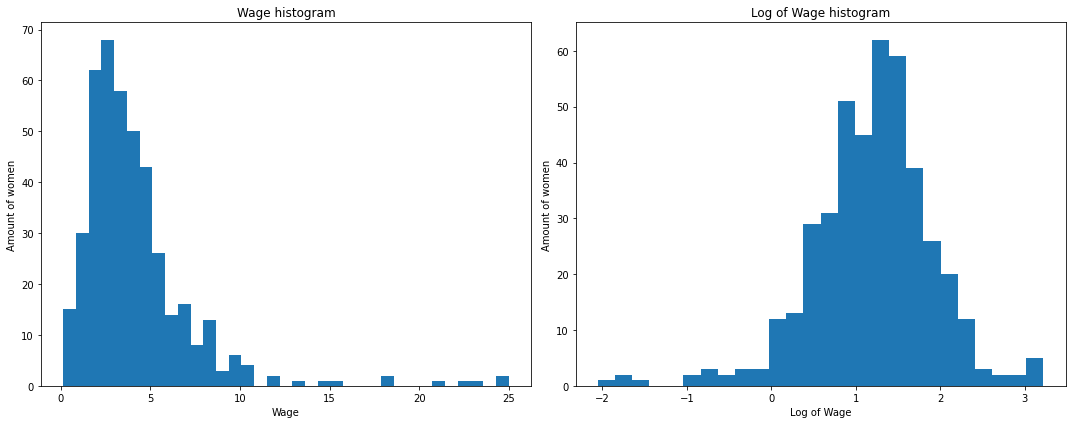

In [419]:
plt.subplots(1, 2, figsize = (15, 6))

plt.subplot(1, 2, 1)
plt.hist(df.loc[:, 'wage'], 'auto')
plt.title('Wage histogram')
plt.xlabel('Wage')
plt.ylabel('Amount of women')

plt.subplot(1, 2, 2)
plt.hist(np.log(df.loc[:, 'wage']), 'auto')
plt.title('Log of Wage histogram')
plt.xlabel('Log of Wage')
plt.ylabel('Amount of women')

plt.tight_layout()
plt.show()

### 1.4
As seen in the heatmap below, the variable with highest correlation with fatheduc is motheduc. And vice versa, they have a correlation of 0.55. This however does indicate some multicollinearity and one should not use both in the same model.

In [420]:
corr = df.loc[:, 'motheduc'].corr(df.loc[:, 'fatheduc'])
print(f'The correlation between fatheduc and motheduc is {corr}')

The correlation between fatheduc and motheduc is 0.554063218431168


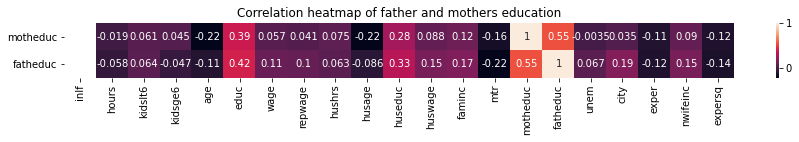

In [421]:
plt.figure(figsize = (15, 1))
corrMatrix = df.corr()[14:16]
sn.heatmap(corrMatrix, annot=True)
plt.title('Correlation heatmap of father and mothers education')
plt.show()

### 1.5
By plotting the effect on wage of each independent variables, one is simulating their effect assuming they are the only variables. But they aren't, in order to obtain a ceteris paribus analysis one must look at the multiple regression and hold the variables not analyzed constant. So, by just plotting other variables against the wage you aren't "holding other factors fixed".

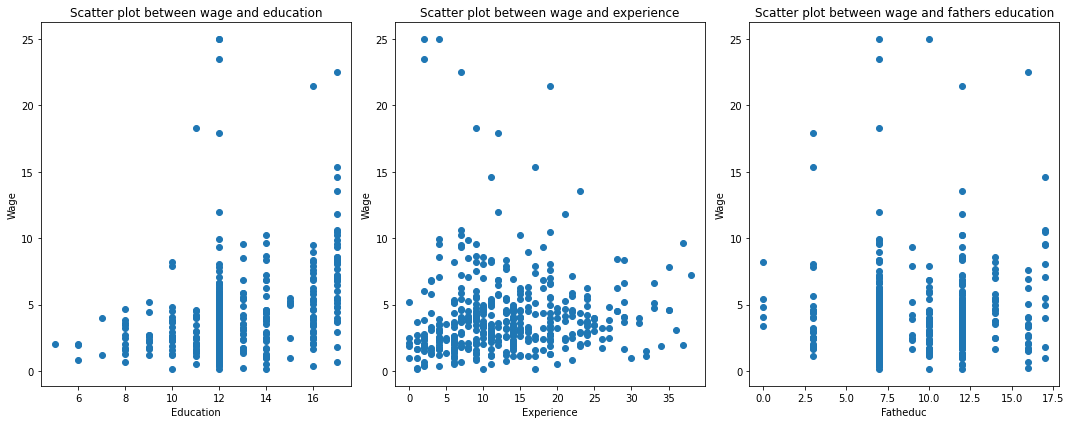

In [422]:
plt.subplots(1, 3, figsize=(15, 6))

plt.subplot(131)
plt.scatter(df.loc[:, 'educ'], df.loc[:, 'wage'])
plt.title('Scatter plot between wage and education')
plt.xlabel('Education')
plt.ylabel('Wage')

plt.subplot(132)
plt.scatter(df.loc[:, 'exper'], df.loc[:, 'wage'])
plt.title('Scatter plot between wage and experience')
plt.xlabel('Experience')
plt.ylabel('Wage')

plt.subplot(133)
plt.scatter(df.loc[:, 'fatheduc'], df.loc[:, 'wage'])
plt.title('Scatter plot between wage and fathers education')
plt.xlabel('Fatheduc')
plt.ylabel('Wage')

plt.tight_layout()
plt.show()

### 1.6
In a proper model, every estimated variable must have $ E(\widehat β) = β $, and thus be unbiased. Therefore, the error term should have $E(u) =0$, the fundamental hypothesis. However, if one underspecifies the model it usually causes ommitted variable bias. Which causes a bias on the affected variables, this bias can be insignificant, but it can also render the model useless. This only does not happen if the corresponding samples between the omitted variable and the other variable are uncorrelated.  

### 1.7
The resulting residual histogram has many positive outliers, and because its mean is zero by definition, the resulting curve seems visually negatively skewed. 

In [423]:
size = np.shape(df.loc[:, 'wage'])
X = np.column_stack((np.ones(size), df.loc[:, 'city'], df.loc[:, 'educ'], df.loc[:, 'exper'], df.loc[:, 'nwifeinc'],
                     df.loc[:, 'kidslt6'], df.loc[:, 'kidsge6']))
y=df.loc[:, 'wage']
model=sm.OLS(y,X)
results = model.fit() 
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     10.23
Date:                Sun, 22 Nov 2020   Prob (F-statistic):           1.41e-10
Time:                        14:02:40   Log-Likelihood:                -1090.0
No. Observations:                 428   AIC:                             2194.
Df Residuals:                     421   BIC:                             2222.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.4035      0.963     -2.495      0.0

In [424]:
params = np.array(results.params)
residuals = -np.matmul(X, params) + y

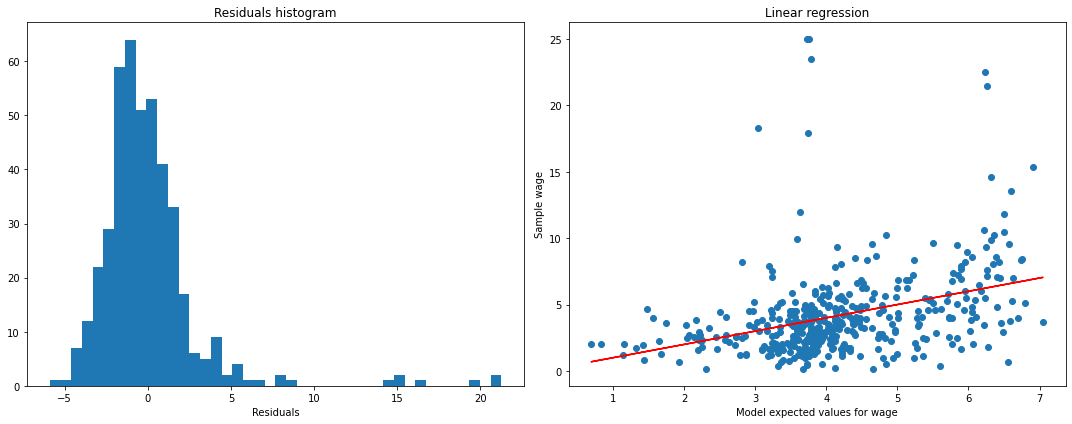

In [425]:
plt.subplots(1, 2, figsize = (15, 6))

plt.subplot(121)
plt.hist(residuals, 'auto')
plt.title('Residuals histogram')
plt.xlabel('Residuals')

plt.subplot(122)
plt.scatter(np.matmul(X, params), y)
plt.plot(np.matmul(X, params), np.matmul(X, params), color = 'red')
plt.title('Linear regression')
plt.xlabel('Model expected values for wage')
plt.ylabel('Sample wage')

plt.tight_layout()
plt.show()

### 1.8
By applying log I was able to eliminate the observed outliers and make a more centered and precise residuals curve. One can see that the residuals are generally contained between $[-1, 1]$, much improved from the previous $[-5, 5]$.

In [426]:
ylog = pd.to_numeric(df.loc[:,'lwage'], downcast= 'float')
model_log=sm.OLS(ylog,X)
results_log = model_log.fit() 
print(results_log.summary())

                            OLS Regression Results                            
Dep. Variable:                  lwage   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     12.92
Date:                Sun, 22 Nov 2020   Prob (F-statistic):           2.00e-13
Time:                        14:02:41   Log-Likelihood:                -431.92
No. Observations:                 428   AIC:                             877.8
Df Residuals:                     421   BIC:                             906.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3990      0.207     -1.927      0.0

In [427]:
params_log = np.array(results_log.params)
residuals_log = -np.matmul(X, params_log) + ylog

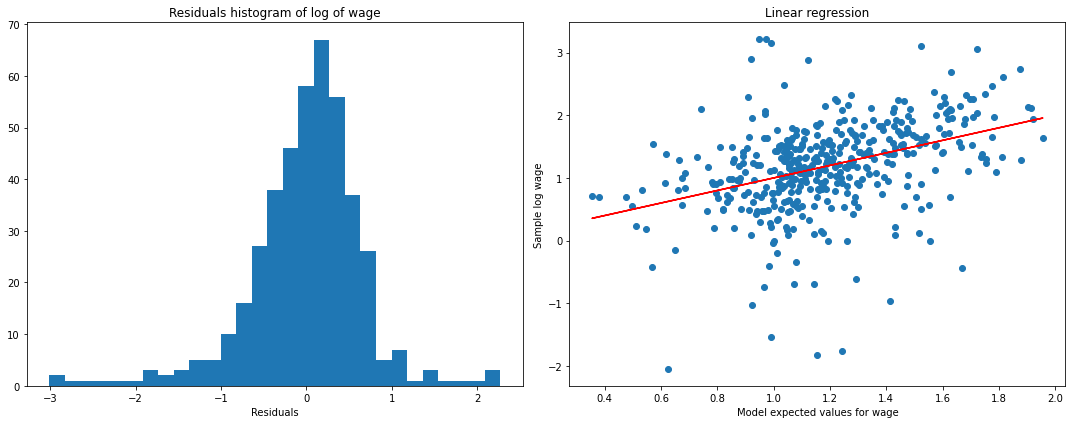

In [428]:
plt.subplots(1, 2, figsize = (15, 6))

plt.subplot(121)
plt.hist(residuals_log, 'auto')
plt.title('Residuals histogram of log of wage')
plt.xlabel('Residuals')

plt.subplot(122)
plt.scatter(np.matmul(X, params_log), ylog)
plt.plot(np.matmul(X, params_log), np.matmul(X, params_log), color = 'red')
plt.title('Linear regression')
plt.xlabel('Model expected values for wage')
plt.ylabel('Sample log wage')

plt.tight_layout()
plt.show()

### 1.9
Testing the hypothesis that nwifeinc = 0. 

$H_0: nwifeinc = 0$ and $H_1: nwifeinc \ne 0$

First, we have to determine its t-value, which was found by the OLS regression beforehand. With this we find its corresponding pvalue with the t.sf function. Obtaining a Pvalue of 14%, which is greater than 1%, 5% and 10% rejecting all alternative hypotheses.

In [429]:
SSR = np.matmul(residuals_log, residuals_log.T)
n, k = X.shape
sig2 = SSR/(n - k-1)
var = sig2*np.linalg.inv(X@X.T)

In [430]:
tvalue = results_log.tvalues[4]
pvalue = t.sf(tvalue, results_log.df_resid)*2 #it was multiplied by two because this is a two tailed test
print(f'The p value obtained is {pvalue:.2f}')

The p value obtained is 0.14


### 1.10
In order to test if $wifeinc \neq 0.01$

$H_0: nwifeinc = 0.01$ and $H_1: nwifeinc \ne 0.01$

we must first recalculate the tvalue of the new parameter. For this we use the formula $t = \frac{\widehat β - 0.01}{se(\widehat β_j)}$. Then find the corresponding p-value, of 0.24. Upon observing the values we affirm that nwifeinc is not statistically different to 0.01

In [431]:
tvalue = (results_log.params[4]-0.001)/results_log.bse[4]
pvalue = t.sf(tvalue, results_log.df_resid)*2
print(f'The p value obtained is {pvalue:.2f}')

The p value obtained is 0.24


### 1.11
For the hypothesis that $ H_0: β_1 = 0.05$ and $β_4 = 0.01 $ we calculate the F value and transform it into a P value. To discover that it resides in the 74th percentile, and thus we reject the alternative hypothesis.


In [432]:
#unrestricted model
SSRur = np.matmul(residuals_log, residuals_log.T)
q = 2
DFur = results_log.df_resid

#restricted model
y11 = ylog - df.loc[:, 'nwifeinc']*0.01 - df.loc[:, 'city']*0.05
X11 = np.column_stack((np.ones(size), df.loc[:, 'educ'], df.loc[:, 'exper'], df.loc[:, 'kidslt6'],
                       df.loc[:, 'kidsge6']))
model11=sm.OLS(y11,X11)
results11 = model11.fit()
params11 = results11.params
residuals11 = y11 - np.matmul(X11, params11)
SSRr = np.matmul(residuals11, residuals11.T)
F = ((SSRr - SSRur)/q)/(SSRur/DFur)
print(f'The resulting pvalue is {stats.f.sf(F, q, DFur)}')


The resulting pvalue is 0.2637267052506216


### 1.12
When we apply the F test like the previous questions to try to equate the corresponding coefficients for all the variables except for experience and education we arrive at a p value of 0.31. This means that all the other variables can be bundled into the error term and their "noise" could have expected value of zero. Thus, one could assume a two variable regression with only experience and education in order to accurately create the model, illustrated by the graph produced below. By removing all other parameters from the unrestricted model and by plotting a restricted model with only education and experience, the result is basically the same, proving that the other coefficients are indeed surplus to this regression.

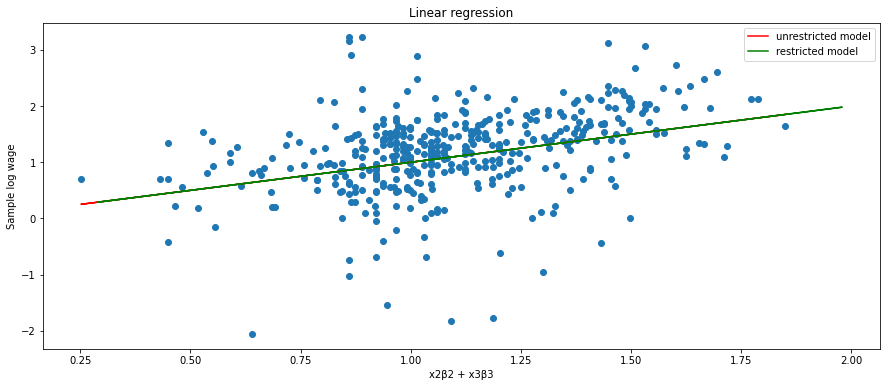


The resulting pvalue is 0.3115405189660125


In [433]:
params12 = results_log.params
q=3
params12[1] = 0 
params12[4] = 0 
params12[5] = 0
params12[6] = 0

X12 = np.column_stack((np.ones(size), df.loc[:, 'educ'], df.loc[:, 'exper']))
model12=sm.OLS(ylog,X12)
results12 = model12.fit()
params122 = results12.params
residuals12 = ylog - np.matmul(X12, params122)
SSRr = np.matmul(residuals12, residuals12.T)
F = ((SSRr - SSRur)/q)/(SSRur/DFur)

plt.figure(figsize = (15, 6))
plt.scatter(np.matmul(X, params12), ylog)
plt.plot(np.matmul(X, params12), np.matmul(X, params12), color = 'red', label = 'unrestricted model')
plt.plot(np.matmul(X12, params122), np.matmul(X12, params122), color = 'green', label = 'restricted model')                  
plt.title('Linear regression')
plt.legend()
plt.xlabel('x2β2 + x3β3')
plt.ylabel('Sample log wage')
plt.show()

print()
print(f'The resulting pvalue is {stats.f.sf(F, q, DFur)}')

### 1.13
Assuming a variable $θ = β_5 - β_6$. 

We have:
$y = β_0 + x_1β_1 + x_2β_2 + x_3β_3 + x_4β_4 + x_5(θ + β_6) +x_6β_6$

$y = β_0 + x_1β_1 + x_2β_2 + x_3β_3 + x_4β_4 + x_5θ +(x_6 + x_5)β_6$

Where the null hypothesis: $H_0: θ = 0$

The results indicate a tstatistic equal to 0.37 which is less than the corresponding tstatistic for 97.5th percentile. This indicates that we reject the alternative hypothesis, and the coefficients associated to kidsge6 and kidslt6 aren't different. This result was expected by the conclusion in 1.12, since both the coefficients for kidsge6 and kidslt6 failed to prove that they are different than 0.

In [434]:
X13 = np.column_stack((np.ones(size), df.loc[:, 'city'], df.loc[:, 'educ'], df.loc[:, 'exper'], df.loc[:, 'nwifeinc'],
                     df.loc[:, 'kidslt6'], df.loc[:, 'kidsge6'] + df.loc[:, 'kidslt6']))
model13=sm.OLS(ylog,X13)
results13 = model13.fit()
tvalue = np.abs(results13.tvalues[5])
pvalue = t.sf(tvalue, results13.df_resid)*2
print(f'The p value obtained is {pvalue:.2f}')

The p value obtained is 0.71


### 1.14

To test linear heteroskedasticity we must first propose the unrestraint model:


\begin{equation}
u^2 = δ_0 + δ_1x_1 + δ_2x_2 + δ_3x_3 + δ_4x_4 + δ_5x_5 + δ_6x_6
\end{equation}


Assuming that: $H_0: δ_0 =δ_1 =δ_2=δ_3=δ_4=δ_5=δ_6=0$ and that $H_1: !(H_0)$

In [435]:
u2 = residuals**2
X14 = np.column_stack((np.ones(size), df.loc[:, 'city'], df.loc[:, 'educ'], df.loc[:, 'exper'], df.loc[:, 'nwifeinc'],
                     df.loc[:, 'kidslt6'], df.loc[:, 'kidsge6']))
model14=sm.OLS(u2,X14)
results14 = model14.fit()
#print(results14.summary())

print(f'The resulting pvalue is {stats.f.sf(results14.fvalue, q, results14.df_resid):.2f}')

The resulting pvalue is 0.19


For an alpha of 0.05 the alternative hypothesis is rejected and the model isn't heteroskedastic. 

### 1.15
Disclaimer: the question asks to consider women under 30 but that yielded no results.

I remade Question 8 in function format and hypothesis tested to see which variables are equal and which variables are different from zero. On both cases it yielded similar results to number 8, implying that only education and experience aren't insignificant predictors of wage.

One interesting result is the proportion of relevance of education in relation to experience. I used $\frac{β_{educ}}{β_{educ}+β_{exp}}$ in order to estimate how much of the increase in wage is due to each coefficient. This analysis shows that for the older subgroup experience is more important than it is for the younger group.

In [436]:
s1 = df.loc[:, 'age'] < 30 #It is always false
s2 = (df.loc[:, 'age'] >= 30) & (df.loc[:, 'age'] <= 43)
s3 = df.loc[:, 'age'] > 43
print()

In [437]:
def Q8(s):
    model=sm.OLS(ylog[s],X[s])
    results = model.fit() 
    print(results.summary())
    params = np.array(results.params)
    residuals = -np.matmul(X[s], params) + ylog[s]
    
    plt.subplots(1, 2, figsize = (15, 6))

    plt.subplot(121)
    plt.hist(residuals, 'auto')
    plt.title('Residuals histogram of log of wage')
    plt.xlabel('Residuals')

    plt.subplot(122)
    plt.scatter(np.matmul(X[s], params), ylog[s])
    plt.plot(np.matmul(X[s], params), np.matmul(X[s], params), color = 'red')
    plt.title('Linear regression')
    plt.xlabel('Model expected values for wage')
    plt.ylabel('Sample log wage')

    plt.tight_layout()
    plt.show()
    
    columns = ['Constant', 'city', 'educ', 'exper', 'nwifeinc', 'kidslt6','kidsge6']
    
    #threshold95 = t.ppf(0.975, results.df_resid)
    #print(f'The critical value for a two-tail test at 95% confidence is {threshold95}')
    for i in range(1, len(columns)):
        tvalue= results.tvalues[i]
        pvalue = t.sf(np.abs(tvalue), results.df_resid)*2
        print(f'The p-value for {columns[i]} is {pvalue}')
        
    print(f'The influence of education on wage is {results.params[2]/(results.params[2]+results.params[3])*100:.2f}%')

                            OLS Regression Results                            
Dep. Variable:                  lwage   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     7.888
Date:                Sun, 22 Nov 2020   Prob (F-statistic):           9.37e-08
Time:                        14:02:44   Log-Likelihood:                -248.69
No. Observations:                 242   AIC:                             511.4
Df Residuals:                     235   BIC:                             535.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5412      0.318     -1.702      0.0

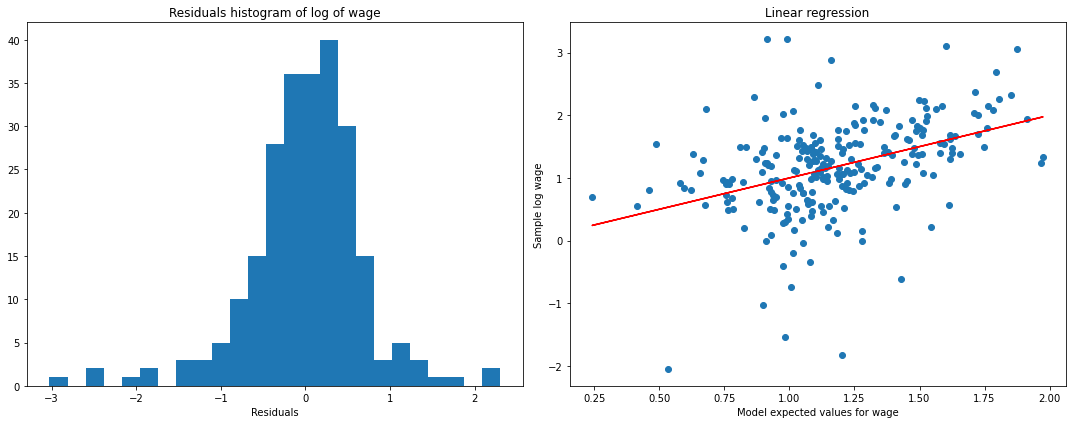

The p-value for city is 0.35842516923702805
The p-value for educ is 9.375600037945542e-07
The p-value for exper is 0.01173559100432568
The p-value for nwifeinc is 0.5991598262178506
The p-value for kidslt6 is 0.321230107389119
The p-value for kidsge6 is 0.5211482531076266
The influence of education on wage is 85.27%


In [438]:
Q8(s2)

                            OLS Regression Results                            
Dep. Variable:                  lwage   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     5.925
Date:                Sun, 22 Nov 2020   Prob (F-statistic):           1.15e-05
Time:                        14:02:45   Log-Likelihood:                -179.89
No. Observations:                 186   AIC:                             373.8
Df Residuals:                     179   BIC:                             396.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3232      0.276     -1.173      0.2

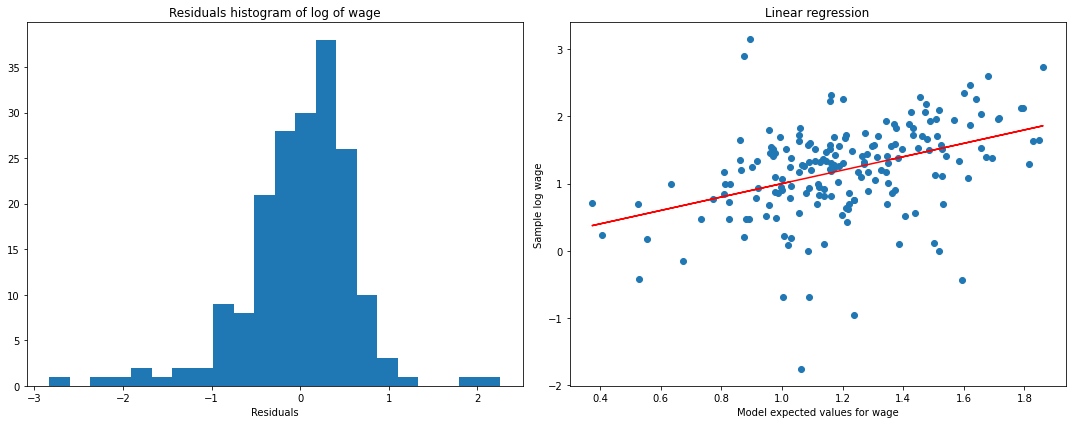

The p-value for city is 0.8645255757403176
The p-value for educ is 3.752472096494833e-05
The p-value for exper is 0.0026648873814397282
The p-value for nwifeinc is 0.051898505490269406
The p-value for kidslt6 is 0.9781041255314886
The p-value for kidsge6 is 0.6270895419145271
The influence of education on wage is 82.70%


In [439]:
Q8(s3)

### 1.16
To insert a new binary variable means to analyze if by dividing the two datasets, the data behaves differently.
So the following model is proposed, defining age as a binary variable that is zero if the person is under 43 and 1 if the person is over said age:
$$y = \beta_0 + age\delta_0 + (\beta_1+age\delta_1)x_1 + (\beta_2+age\delta_2)x_2 + (\beta_3+age\delta_3)x_3 + (\beta_4+age\delta_4)x_4 + (\beta_5+age\delta_5)x_5 + (\beta_6+age\delta_6)x_6 $$

And the null hypothesis is that different age groups don't follow different age models, thus:
$$H_0: \delta_0 = \delta_1=\delta_2=\delta_3=\delta_4=\delta_5=\delta_6=0$$

To test this a Fisher test was applied which resulted in a p-value of 0.55. Rejecting the alterative hypothesis and insuring that both age groups are represented by the same model.

In [450]:
#unrestricted model
s3=s3*1 #transforms to a int vector with 1s and 0s
X16ur = np.column_stack((np.ones(size), df.loc[:, 'city'], df.loc[:, 'educ'], df.loc[:, 'exper'], 
                         df.loc[:, 'nwifeinc'], df.loc[:, 'kidslt6'], df.loc[:, 'kidsge6'], np.ones(size)*s3, 
                         df.loc[:, 'city']*s3, df.loc[:, 'educ']*s3, df.loc[:, 'exper']*s3, 
                         df.loc[:, 'nwifeinc']*s3, df.loc[:, 'kidslt6']*s3, df.loc[:, 'kidsge6']*s3))
model16ur=sm.OLS(ylog,X16ur)
results16ur = model16ur.fit()

residuals16ur = ylog - X16ur@results16ur.params

SSRur = residuals16ur@residuals16ur.T
Dfur = results16ur.df_resid
q = 7

#restricted model
X16r = np.column_stack((np.ones(size), df.loc[:, 'city'], df.loc[:, 'educ'], df.loc[:, 'exper'], 
                       df.loc[:, 'nwifeinc'], df.loc[:, 'kidslt6'], df.loc[:, 'kidsge6']))
model16r = sm.OLS(ylog, X16r)
results16r = model16r.fit()

residuals16r = ylog - X16r@results16r.params
SSRr = residuals16r@residuals16r.T

F = ((SSRr - SSRur)/q)/(SSRur/DFur)

print(f'The resulting pvalue is {stats.f.sf(F, q, Dfur)}')

The resulting pvalue is 0.5545580860166733


## Part 2 - Time Series
### 2.1

In [466]:
filename = 'quarterly.xls' #If the dataset is not in the same directory as this notebook
#please change the filepath to the correct relative filepath
df2 = pd.read_excel(filename) #import the dataframe
df2.loc[:,'DATE']=pd.to_datetime(df2['DATE']).values #convert the dates to datetime

In [467]:
df2.head()

,DATE,FFR,Tbill,Tb1yr,r5,r10,PPINSA,Finished,CPI,CPICORE,M1NSA,M2SA,M2NSA,Unemp,IndProd,RGDP,Potent,Deflator,Curr
0,1960-01-01,3.93,3.87,4.57,4.64,4.49,31.67,33.20,29.40,18.92,140.53,896.1,299.40,5.13,23.93,2845.3,2824.2,18.521,31.830
1,1960-04-01,3.70,2.99,3.87,4.30,4.26,31.73,33.40,29.57,19.00,138.40,903.3,300.03,5.23,23.41,2832.0,2851.2,18.579,31.862
2,1960-07-01,2.94,2.36,3.07,3.67,3.83,31.63,33.43,29.59,19.07,139.60,919.4,305.50,5.53,23.02,2836.6,2878.7,18.648,32.217
3,1960-10-01,2.30,2.31,2.99,3.75,3.89,31.70,33.67,29.78,19.14,142.67,932.8,312.30,6.27,22.47,2800.2,2906.7,18.700,32.624
4,1961-01-01,2.00,2.35,2.87,3.64,3.79,31.80,33.63,29.84,19.17,142.23,948.9,317.10,6.80,22.13,2816.9,2934.8,18.743,32.073


### 2.2

Considering $inf(t) = \frac{CPI(t)-CPI(t-1)}{CPI(t-1)} $. The inflation curve seems to represent American inflation, with high peaks in the 70s and 80s due to keynesian economic policy to get out of recession and a great low in 2008 due to the financial crisis.

In [468]:
inf = []
inf.append(0)
for i in range(1, len(df2['CPI'])):
    inf.append(100*(df2.loc[i, 'CPI']-df2.loc[i-1, 'CPI'])/df2.loc[i-1, 'CPI'])
inf= np.array(inf)

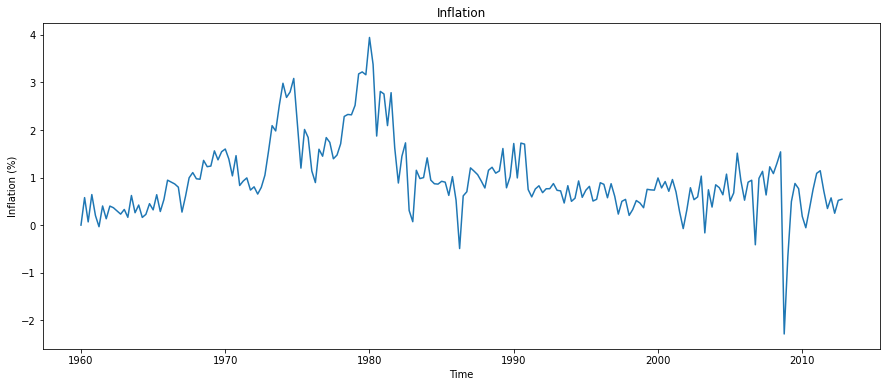

In [469]:
plt.figure(figsize=(15, 6))
plt.plot(df2['DATE'], inf)
plt.title('Inflation')
plt.ylabel('Inflation (%)')
plt.xlabel('Time')

plt.show()

### 2.3
The autocorrelation function is a function that measures the correlation of a time series with itself given a certain lag. Its graph has the corresponding lag on the x axis. Its autocorrelation graph indicates it is not an MA function because it enters the 95% confidence zone gradually.

The partial autocorrelation function also measures correlation but only takes into account the direct correlation between itself and its lag. For a AR(q), therefore, we should expect values greater than zero up until lag equals q. Looking at the graphs generated one can estimate that inf might be an AR(3) function. 

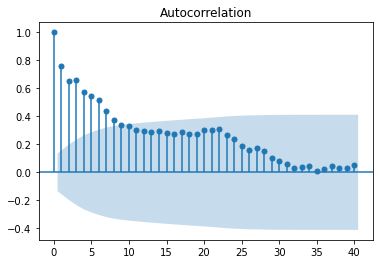

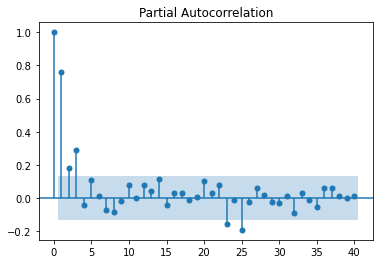

In [470]:
x = plot_acf(inf, lags=40, fft= False, alpha = 0.05)
x = plot_pacf(inf, lags=40, alpha = 0.05)

### 2.4
An ergodic process is stationary, but a stationary process isn't necessarily ergodic. An ergodic process happens when the expected value of all realizations of a random process is equal to the temporal average of a single realization. Therefore, if we have an ergodic process, with sufficient statistical information we can infer sufficient information without needing multiple realizations of the same process. 

A spurious regression is a misleading regression of a non-stationary process that implies a relationship between independent variables.

### 2.5
In 2.3 it was estimated that q was around 3. So I calculated the AIC and BIC for q from 1 to 10. The q that minimized both was q = 3. Therefore inf is an AR(3) process.

In [471]:
import statsmodels.tsa.api as smt
aicv = []
bicv = []
for i in range(1, 11):
    mdl = smt.AR(inf).fit(maxlag=i) 
    mdl.params
    aicv.append(mdl.aic)
    bicv.append(mdl.bic)

/Users/gabrielmedeiros/opt/anaconda3/envs/MODS202/lib/python3.7/site-packages/statsmodels/tsa/ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_D

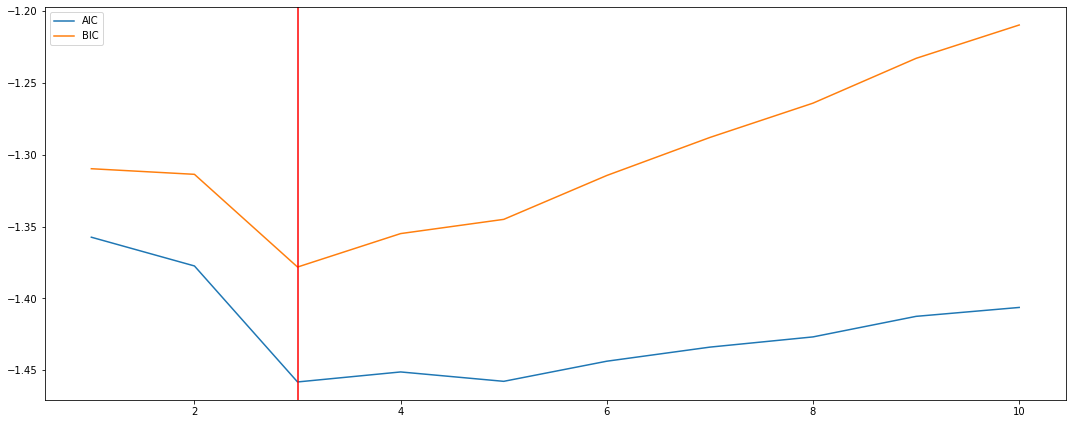

In [472]:
plt.figure(figsize = (15, 6))
plt.plot(range(1, 11), aicv, label = 'AIC')
plt.plot(range(1, 11), bicv,label = 'BIC')
plt.axvline(3, color = 'Red')
plt.legend()
plt.tight_layout()
plt.show()

### 2.6

In [473]:
X26 = np.column_stack((np.ones(len(inf)), inf))
model=sm.OLS(df2.loc[:, 'Unemp'],X26)
results = model.fit() 
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Unemp   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                   0.02604
Date:                Sun, 22 Nov 2020   Prob (F-statistic):              0.872
Time:                        14:40:19   Log-Likelihood:                -401.84
No. Observations:                 212   AIC:                             807.7
Df Residuals:                     210   BIC:                             814.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0593      0.179     33.774      0.0

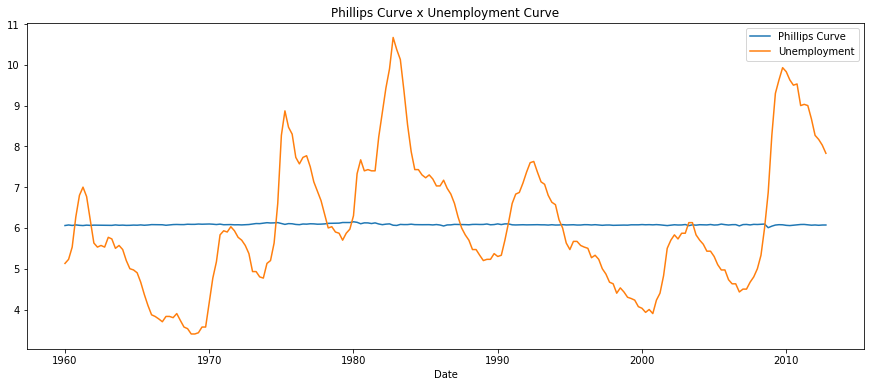

In [474]:
plt.figure(figsize=(15, 6))
plt.plot(df2.loc[:, 'DATE'], results.params[0]+inf*results.params[1], label = 'Phillips Curve')
plt.plot(df2.loc[:, 'DATE'], df2.loc[:, 'Unemp'], label = 'Unemployment')
plt.title('Phillips Curve x Unemployment Curve')
plt.xlabel('Date')
plt.legend()
plt.show()

### 2.7
To test the error correlation one must calculate the residuals and regress them using an AR(1) model, and use hypothesis testing to see if there is a serial correlation. Our null hypothesis for $u_t = ρu_{t-1} + e$ is $H_0:ρ = 0$ and $H_1: ρ \neq 0$. The pvalue clearly rejects the null hypothesis and proves a serial correlation. Also, by plotting the acf and pacf, one can confirm the same result, as it indicates that there is partial autocorrelation between u and its first three delays.

In [481]:
def delay(arr, t):
    zero = np.zeros(len(arr))
    zero[-t:] = arr[0:len(arr)+t]
    return zero

In [482]:
u = np.array(df2.loc[:, 'Unemp'] - (results.params[0]+results.params[1]*inf))
u1 = delay(u, -1)

X27 = np.column_stack((np.ones(len(u)), u1))
model27=sm.OLS(u,X27)
results27 = model27.fit() 


print(f'The pvalue obtained for hypothesis H0 is {t.sf(results27.tvalues[1], results27.df_resid)}')
print(f'The value obtained for ρ is {results27.params[1]}')

The pvalue obtained for hypothesis H0 is 3.182795579211221e-143
The value obtained for ρ is 0.9797752852466198


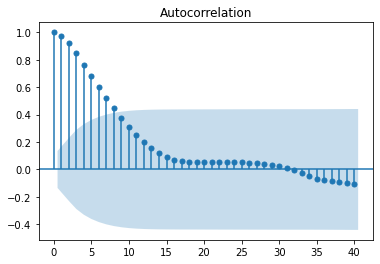

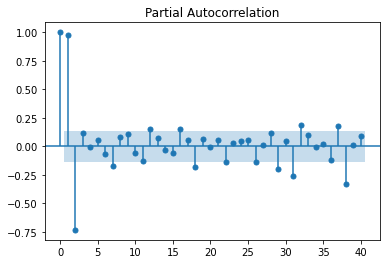

In [483]:
x = plot_acf(u, lags=40, fft= False, alpha = 0.05)
x = plot_pacf(u, lags=40, alpha = 0.05)

In [484]:
u1 = delay(u, -1)
u2 = delay(u, -2)

X27aux = np.column_stack((np.ones(len(u)), u1, u2))
model27aux=sm.OLS(u,X27aux)
results27aux = model27aux.fit() 
print(results27aux.summary())

print(f'The resulting pvalue is {stats.f.sf(results27aux.fvalue, 2, DFur)}')


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     3923.
Date:                Sun, 22 Nov 2020   Prob (F-statistic):          1.86e-166
Time:                        14:43:07   Log-Likelihood:                -14.755
No. Observations:                 212   AIC:                             35.51
Df Residuals:                     209   BIC:                             45.58
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.018      0.106      0.9

### 2.8
To correct an AR(1) regression, we have to do a couple of transformations:

$\widehat y_t = y_t - ρy_{t-1}$

$\widehat x_t = x_t - ρx_{t-1}$

And the regression becomes:

$\widehat y_t = (1-ρ)β_0 + \widehat x_tβ_1$

In [584]:
ro = results27.params[1]
yh = df2.loc[:, 'Unemp'] - delay(df2.loc[:, 'Unemp'], -1)*ro
xh = inf - delay(inf, -1)*ro

X28 = np.column_stack((np.ones(len(xh))*(1-ro), xh))
model28 = sm.OLS(yh, X28)
results28 = model28.fit()

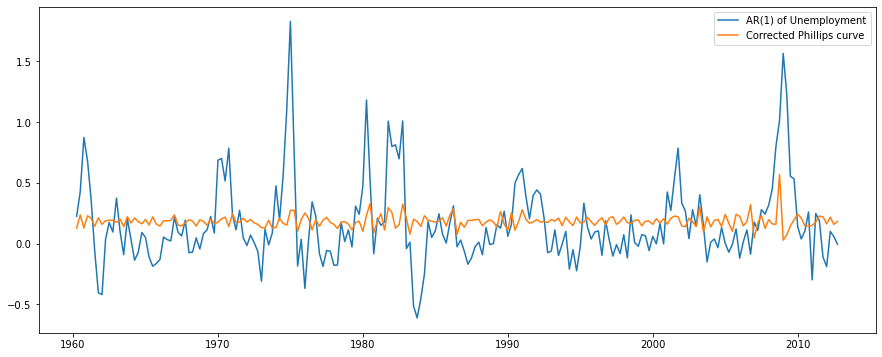

In [585]:
plt.figure(figsize=(15, 6))
plt.plot(df2['DATE'][1:], yh[1:], label = 'AR(1) of Unemployment')
plt.plot(df2['DATE'][1:], (X28@results28.params)[1:], label = 'Corrected Phillips curve')
plt.legend()
plt.show()

The Phillips curve has visibly come closer, but it is still far from actually representing the model. To perform the AR(2) correction as well.

In [492]:
ro1 = results27aux.params[1]
ro2 = results27aux.params[2]

yh = df2.loc[:, 'Unemp'] - delay(df2.loc[:, 'Unemp'], -1)*ro1 - delay(df2.loc[:, 'Unemp'], -2)*ro2
xh = inf - delay(inf, -1)*ro1 - delay(inf, -2)*ro2

X28aux = np.column_stack((np.ones(len(xh))*(1-ro1-ro2), xh))
model28aux = sm.OLS(yh, X28aux)
results28aux = model28aux.fit()

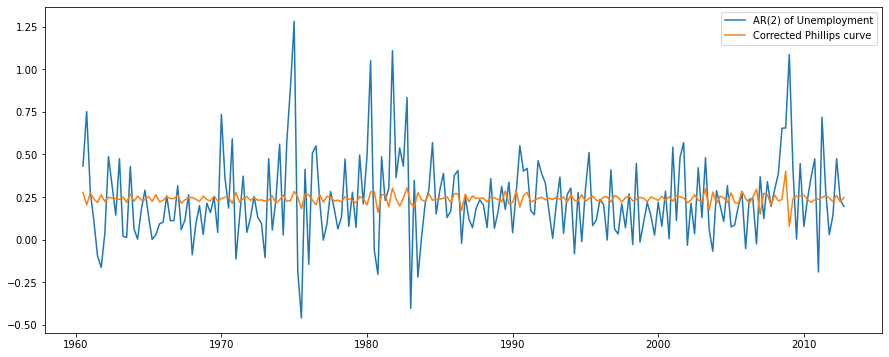

In [493]:
plt.figure(figsize=(15, 6))
plt.plot(df2['DATE'][2:], yh[2:], label = 'AR(2) of Unemployment')
plt.plot(df2['DATE'][2:], (X28aux@results28aux.params)[2:], label = 'Corrected Phillips curve')
plt.legend()
plt.show()

### 2.9
In order to test the stability the periods selected were from 1970-1980 and 1990-2000.

The model proposed is the one obtained before int the form of an ARMA(1, 1):
$$unemp_t = \beta_0 + \beta_1unemp_{t-1} + \delta_1inf_{t-1} + \gamma_0D(t) + \gamma_1D(t)unemp_{t-1}+\gamma_2D(t)inf(t-1)$$

Where D(t) = 1 if 1990 <= t <= 2000. When only 1970-1980 and 1990-2000 as the regression's domain. Then, the hypothesis would be: $$H_0: \gamma_0=\gamma_1=\gamma_2=0$$ which implies stationarity, because if any gamma were different from zero the mean would change over time, violating stationarity.

The p-value of the Fisher statistic was $$p = 0.001$$ which is smaller than 0.05, rejecting the null hypothesis. With this information one can infer that there is seasonality in our ARMA(1, 1) model.

In [546]:
s1 = (df2.loc[:, 'DATE'] <= np.datetime64('1980-01-01').astype('datetime64[ns]')) & (df2.loc[:, 'DATE'] >= np.datetime64('1970-01-01').astype('datetime64[ns]'))

s2 = (df2.loc[:, 'DATE'] <= np.datetime64('2000-01-01').astype('datetime64[ns]')) & (df2.loc[:, 'DATE'] >= np.datetime64('1990-01-01').astype('datetime64[ns]'))

s = s1|s2

saux = (df2.loc[:, 'DATE'][s] <= np.datetime64('2000-01-01').astype('datetime64[ns]')) & (df2.loc[:, 'DATE'][s] >= np.datetime64('1990-01-01').astype('datetime64[ns]'))

In [547]:
unemp = df2['Unemp']
X29 = np.column_stack((np.ones(len(unemp[s])), delay(unemp[s], -1), delay(inf[s], -1), np.ones(len(unemp[s]))*saux,
                                                    delay(unemp[s]*saux, -1), delay(inf[s]*saux, -1)))
model29 = sm.OLS(unemp[s], X29)
results29 = model29.fit()
#print(results29.summary())

In [548]:
#unrestricted model
residuals29ur = unemp[s][1:] - (X29@results29.params)[1:]
SSRur = residuals29ur@residuals29ur.T
DFur = results29.df_resid
q = 3

#restricted model
X29r = np.column_stack((np.ones(len(unemp[s])), delay(unemp[s], -1), delay(inf[s], -1)))
model29r = sm.OLS(unemp[s], X29r)
results29r = model29r.fit()
residuals29r = unemp[s][1:] - (X29r@results29r.params)[1:]
SSRr = residuals29r@residuals29r.T

F = ((SSRr - SSRur)/q)/(SSRur/DFur)

print(f'The resulting pvalue is {stats.f.sf(F, q, Dfur)}')

The resulting pvalue is 0.0009681391762027964


### 2.10

In [611]:
def cut(arr, t):
    return arr[t:]

In [612]:
X210 = np.column_stack((np.ones(len(unemp)-4), cut(delay(inf, -1), 4), cut(delay(inf, -2), 4), cut(delay(inf, -3), 4) , cut(delay(inf, -4), 4), cut(delay(unemp, -1), 4), cut(delay(unemp, -2), 4), cut(delay(unemp, -3), 4), cut(delay(unemp, -4), 4)))
model210 = sm.OLS(unemp[4:], X210)
results210 = model210.fit()
print(results210.summary())

                            OLS Regression Results                            
Dep. Variable:                  Unemp   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     1150.
Date:                Sun, 22 Nov 2020   Prob (F-statistic):          4.14e-162
Time:                        18:33:21   Log-Likelihood:                 5.0779
No. Observations:                 208   AIC:                             7.844
Df Residuals:                     199   BIC:                             37.88
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1464      0.072      2.028      0.0

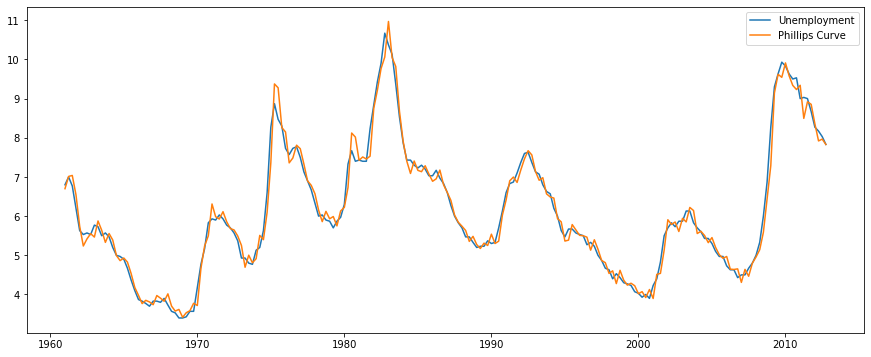

In [613]:
plt.figure(figsize=(15, 6))
plt.plot(cut(df2['DATE'], 4), cut(unemp, 4), label = 'Unemployment')
plt.plot(cut(df2['DATE'], 4), (X210@results210.params), label = 'Phillips Curve')
plt.legend()
plt.show()

In [614]:
#unrestricted model
residuals210 = cut(unemp, 4) - (X210@results210.params)
SSRur = residuals210@residuals210.T
DFur = results210.df_resid
q= 4

#restricted model
X210r = np.column_stack((np.ones(len(unemp)-4), cut(delay(unemp, -1), 4), cut(delay(unemp, -2), 4), cut(delay(unemp, -3), 4), cut(delay(unemp, -4), 4)))
model210r = sm.OLS(cut(unemp, 4), X210r)
results210r = model210r.fit()

residuals210r = cut(unemp, 4) - (X210r@results210r.params)
SSRr = residuals210r@residuals210r.T

F = ((SSRr - SSRur)/q)/(SSRur/DFur)

print(f'The resulting pvalue is {stats.f.sf(F, q, Dfur)}')

The resulting pvalue is 0.005007592637886315


### 2.11
The long run propensity calculated, by taking the sum of the coefficients above, is equal to 0.09. Which means that the long run change in expected value of unemployment for a permanent one unit increase in inflation is 0.09. Practically this means that if the inflation increases by one the unemployment rate should barely change in the long run. We know that these two variables are correlated, and considering that it takes one year for the permanent change to affect all coefficients, one can conclude that a permanent increase in inflation doesn’t affect unemployment a year later, only in the short run.

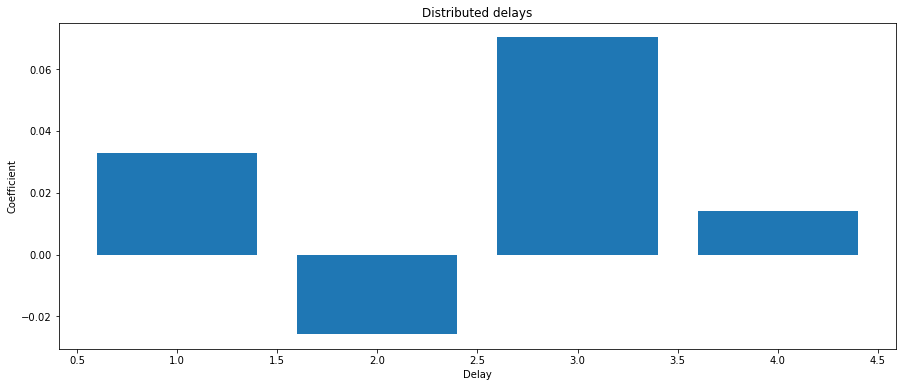

The value obtained for the long run propensity is 0.091


In [623]:
plt.figure(figsize=(15, 6))
plt.bar(range(1, 5), results210.params[1:5])
plt.title("Distributed delays")
plt.ylabel('Coefficient')
plt.xlabel('Delay')
plt.show()
print(f'The value obtained for the long run propensity is {np.sum(results210.params[1:5]):.3f}')